In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
import torch.nn.functional as F
from models.last_layer_models import LLI, train_last_layer_det, get_post_pred_dens

from models.mc_dropout import MCDropoutNet
from models.bnn import BNN, train_bnn
from models.gibbs_sampler import gibbs_sampler, get_pred_post_dist, get_prediction_interval_coverage
from models.vi import fit_vi_post_hoc, fit_vi_post_hoc, predictive_posterior
from models.sg_mcmc import train_sg_mcmc
from tqdm import tqdm

from utils.coverage import get_coverage_gaussian, get_coverage_y_hats

np.random.seed(100)

Text(0.5, 1.0, 'Training/Validation split')

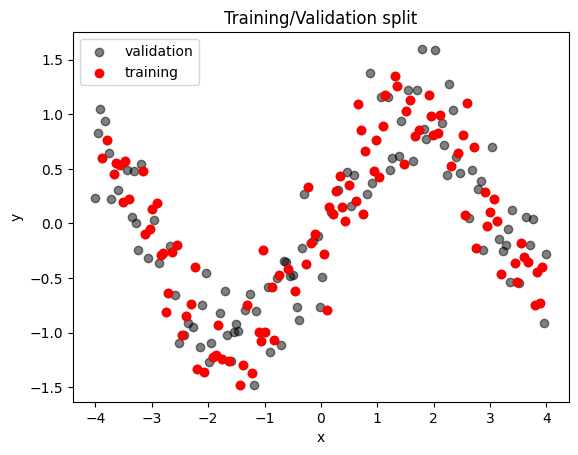

In [2]:
def f(x: float, noise: bool = True, sigma_eps: float = 0.1):
    """Generates a sample y_i from y = sin(x) + varepsilon."""
    y = math.sin(x)
    if noise:
        y += sigma_eps*np.random.randn(1)
    return y

# draw data
sigma_eps = 0.3
xs = np.linspace(-4,4,200)
ys = np.array([f(x = x, noise = True, sigma_eps = sigma_eps) for x in xs])

# sample train indices
train_idx = np.random.choice(len(xs), size=100, replace=False)

xs_train = torch.tensor(xs[train_idx]).unsqueeze(-1).float()
ys_train = torch.tensor(ys[train_idx]).float()

all_idx = np.arange(len(xs))
val_idx = np.setdiff1d(all_idx, train_idx)

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

In [4]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100

100%|██████████| 100/100 [00:00<00:00, 164.75it/s]


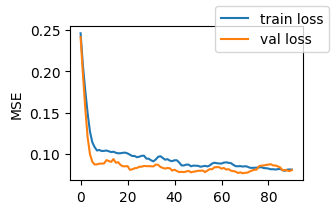

In [5]:
# train deep feature projector psi
lli_net = LLI(model_dims)
sigma_0 = 0.3

lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [6]:
lli_net.eval()

# fit last-layer posterior
Psi = lli_net.get_ll_embedd(xs_train)

In [7]:
lambdas, elbos = fit_vi_post_hoc(ys = ys_train.detach(), Psi = Psi.detach(), 
                lr = 1e-4, num_iter = 50000, 
                method = 'ridge', sigma_eps_sq = 1.0, sigma_0_sq = 1.0)

100%|██████████| 50000/50000 [00:16<00:00, 3068.64it/s]


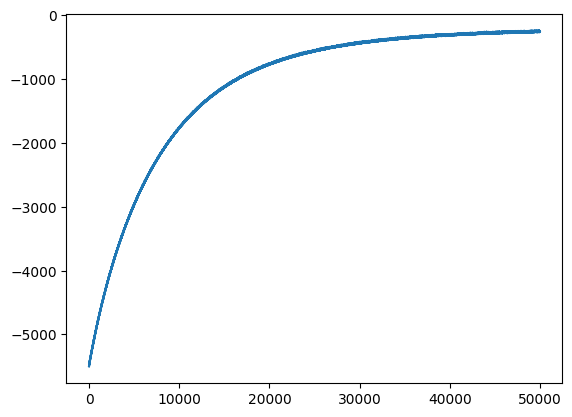

In [8]:
plt.plot(elbos)